Implements a random forest classifier to classify Alzheimer's disease, with steps including:
- Applying Principal Component Analysis (PCA) for dimensionality reduction and feature extraction
- Cross-validation of classification results
- Permutation testing for statistical significance using parallel processing
- Exploring feature importance

In [17]:
# "standard"
import numpy as np

# machine learning and statistics
from sklearn.decomposition import PCA
from scipy.stats import false_discovery_control
import dask.array as da

# plotting
import matplotlib.pyplot as plt

# misc
import time, os
from IPython.display import clear_output

import sys, pickle
from pathlib import Path
script_dir = Path(os.getcwd()).parent
src_dir = script_dir / 'src'
sys.path.append(str(src_dir))
from random_forest import RF, classification_RF_shuffle, iteration_permute, iteration_PCs, iteration_permute_PCs
from visualize import multiclass_summary

clear_output(wait=False)

Create results directory

In [6]:
script_dir = Path(os.getcwd()).parent
results_dir_00 = script_dir / 'results' / 'notebook_00'

results_dir_01 = script_dir / 'results' / 'notebook_01'
os.makedirs(results_dir_01, exist_ok=True)

In [8]:
# Load data file and unpack contents
file_name = results_dir_00 / 'data_preprocessed_xfold.pkl'
with open(file_name, 'rb') as f:
    data_preproc_xfold = pickle.load(f)

data=data_preproc_xfold['data']
labels=np.array(data_preproc_xfold['labels'])

train_idx_fold=data_preproc_xfold['train_idx_fold']
test_idx_fold=data_preproc_xfold['test_idx_fold']

class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']

Decompose data with PCA

In [9]:
data_pca = []
for i in range(len(data)):
    data_pca.append(np.reshape(data[i], (1, -1)))    
data_pca = np.vstack(data_pca[:])

# decompose with PCA and look at various metrics/info
num_comp = 50
pca = PCA(n_components = num_comp)
pca.fit(data_pca)
clear_output(wait=False)

Visualize variance explained and 2D PC representation of dataset

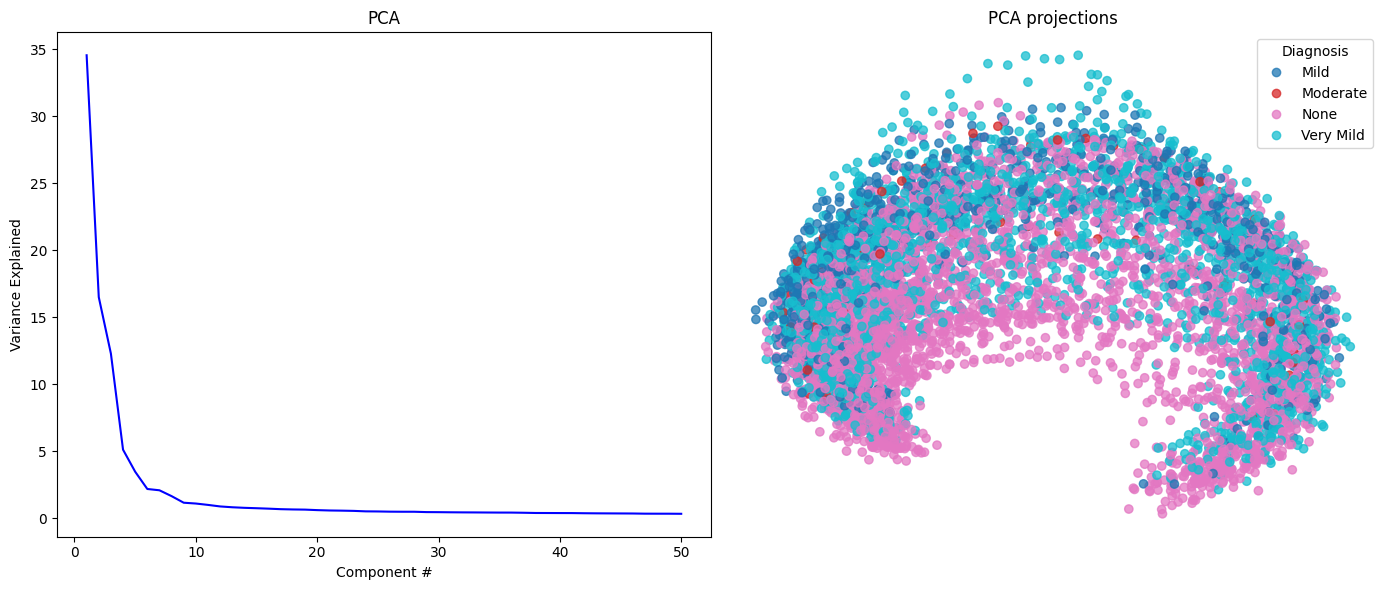

In [10]:
# project data on first two PC's
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_tot = np.matmul(data_pca, loadings[:,:2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot variance explained
ax1.plot(np.linspace(1, num_comp, num_comp), pca.explained_variance_[:num_comp]/sum(pca.explained_variance_[:num_comp]) * 100, 'b')
ax1.set_title('PCA')
ax1.set_xlabel('Component #')
ax1.set_ylabel('Variance Explained')

# Plot first two PCs
s = ax2.scatter(load_tot[:, 0], load_tot[:, 1], c=labels * 2, cmap='tab10', alpha=0.75)
handles, lab = s.legend_elements()
legend = ax2.legend(handles=handles, labels=class_lab, title='Diagnosis', loc='upper right')
ax2.axis('off')
ax2.set_title('PCA projections')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

Apply random forest classifier to first two PCs (5-fold cross validation)

In [11]:

# Perform X-fold cross validation
data_load = np.matmul(data_pca, loadings[:,:2])

predictions_fold = []
true_labels_fold = []
for i in range(len(train_idx_fold)):
    train_data = data_load[train_idx_fold[i],:]
    train_labels = labels[train_idx_fold[i]]
    test_data = data_load[test_idx_fold[i],:]
    test_labels = labels[test_idx_fold[i]]
    predictions, true_labels = RF(train_data, train_labels, test_data, test_labels)
    
    predictions_fold.append(predictions)
    true_labels_fold.append(true_labels)

clear_output(wait=False)

Summarize results

Classification accuracy for fold 1 = 48.98 %
Classification accuracy for fold 2 = 48.67 %
Classification accuracy for fold 3 = 48.52 %
Classification accuracy for fold 4 = 49.45 %
Classification accuracy for fold 5 = 49.61 %

Overall classification accuracy is: 49.05 %



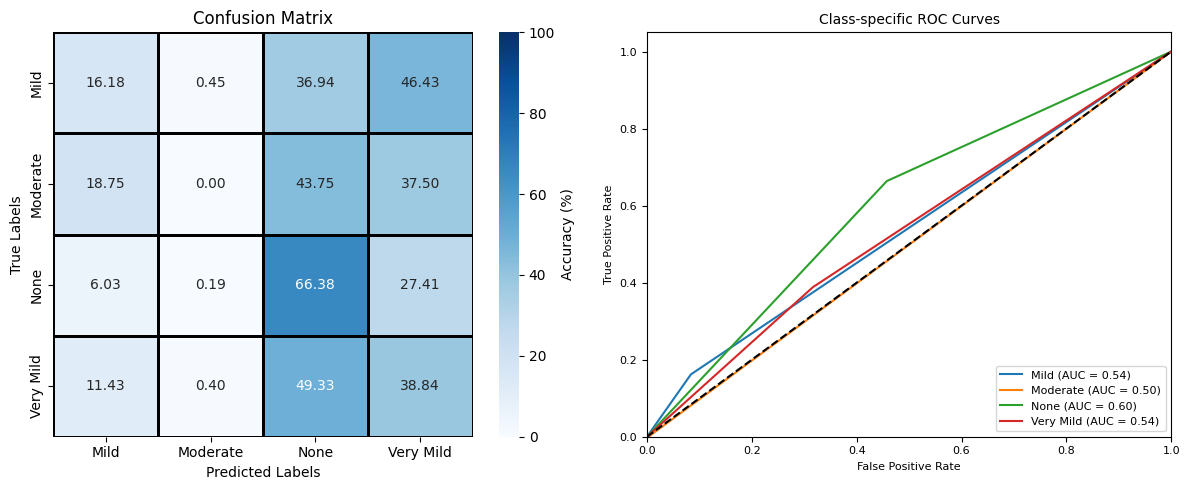

Mild - Precision: 0.24, Recall: 0.16, F1 Score: 0.19
Moderate - Precision: 0.00, Recall: 0.00, F1 Score: 0.00
None - Precision: 0.59, Recall: 0.66, F1 Score: 0.63
Very Mild - Precision: 0.40, Recall: 0.39, F1 Score: 0.39

Data saved to c:\Users\bedelman\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_01\RF_2PC_acc.pkl


In [13]:
# Compare predictions with test labels and compute accuracy
acc_fold = []
for fold in range(len(predictions_fold)):
    result = predictions_fold[fold] - true_labels_fold[fold]
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary, 0)
    acc_fold.append(correct / true_labels_fold[fold].shape[0] * 100)
    print(f"Classification accuracy for fold {fold+1} = {acc_fold[fold]:.2f} %")

print()
print(f"Overall classification accuracy is: {np.mean(acc_fold):.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(np.concatenate(predictions_fold, axis=0), np.concatenate(true_labels_fold, axis=0), class_lab)
print()

# Save results
results = {
    "predictions": predictions_fold,
    "true_labels": true_labels_fold,
    "accuracy": acc_fold
}

file_name = results_dir_01 / 'RF_2PC_acc.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(results, f)

print(f"Data saved to {file_name}")

When using the top two PCs, we see a modest classification rate on the test set. However, there is a clear bias here towards the Moderate AD class, which had the largest bias in the training dataset.

Furthermore, using two PC's  is arbitrary and is easy simply due to visualization purposes. We can also examine accuracy as a function of the number of PCs, and visualize the PC loading maps to interpret the classification results. But first, let's run some statistics to determine if the classification is significant in its current state.

We perform statistical testing to determine if the classification is significantly different (above) chance level. Here, we will do this using permutation testing where we randomly shuffle the training labels before building the classifier and then obtain accuracy values with the original testing labels. By randomly shuffling the training labels hundreds of times, we can build a null distribution and then observe where the "true" classification rate falls.

Since we will be doing a lot of iterations, let's first validate that parallel processing reducs computation time compared to serial processing

In [14]:
# Prepare data for dask parallelization tasks
data_pca_da = da.from_array(data_pca, chunks=(1000, data_pca.shape[1]))
loadings_da = da.from_array(loadings, chunks=(loadings.shape[0], 10))

In [ ]:
# Data set for testing parallelization (just one fold)
data_pca_dask = np.matmul(data_pca_da, loadings_da[:,:2])
load_train = data_load[train_idx_fold[0],:]
train_labels = labels[train_idx_fold[0]]
load_test = data_load[test_idx_fold[0],:]
test_labels = labels[test_idx_fold[0]]

# Serial for loop
start_time = time.time()
acc_shuffle_nodask = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(load_train, train_labels, load_test, test_labels)
    acc_shuffle_nodask.append(acc_tmp)
end_time = time.time()
total_time = end_time - start_time

# Parallel for loop (dask)
start_time1 = time.time()
acc_shuffle_dask = iteration_permute(load_train, train_labels, load_test, test_labels, n_iterations=100)   
end_time1 = time.time()
total_time1 = end_time1 - start_time1

clear_output(wait=False)
display(f"Serial For Loop: {total_time:.2f} seconds")
display(f"Parallel For Loop: {total_time1:.2f} seconds")

We can see that parallelization with dask markedly reduces the computation time (CPU) by ~34% when performing 100 iterations.

Rather than performing all permutations on a single training/testing set, we split these iterations across the different folds. For example, when performing 500 permutations, we perform 100 using each of the five train/test set combinations. The null distribution is build by combining the results from these 5 x 100 permutations to ensure that local patterns in one train/test set do introduce bias.

Total time elapsed: 1351.09 seconds

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_2PC_acc_permute.pkl


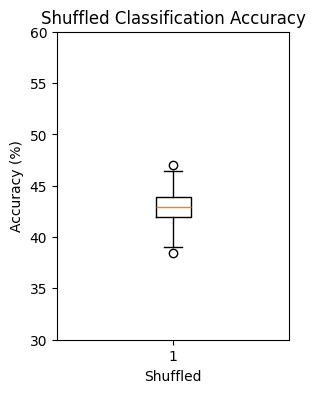

In [0]:
# Permute 100 times per fold for an even distribution
start_time = time.time()

data_pca_dask = np.matmul(data_pca_da, loadings_da[:,:2])
acc_permute_fold = []
for num_fold in range(len(train_idx_fold)):
    
    # Extract data per fold
    load_train = data_load[train_idx_fold[num_fold],:]
    train_labels = labels[train_idx_fold[num_fold]]
    load_test = data_load[test_idx_fold[num_fold],:]
    test_labels = labels[test_idx_fold[num_fold]]

    acc_permute = []
    for i in range(2):
        acc_tmp=iteration_permute(load_train, train_labels, load_test, test_labels, n_iterations=50)
        acc_permute = np.concatenate((acc_permute, acc_tmp), axis=0)

    acc_permute_fold.append(acc_permute)

acc_permute_tot = np.concatenate(acc_permute_fold, axis=0)

plt.figure(figsize=(3, 4))
b = plt.boxplot(acc_permute_tot)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time elapsed: {total_time:.2f} seconds")
print()

# Save results
file_name = results_dir_01 / 'RF_2PC_acc_permute.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(acc_permute_tot, f)

print(f"Data saved to {file_name}")


Determine significance of classification accuracy using a permutation test

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"

file_name = results_dir_01 / 'RF_2PC_acc.pkl'
with open(file_name, 'rb') as f:
    results = pickle.load(f)

file_name = results_dir_01 / 'RF_2PC_acc_permute.pkl'
with open(file_name, 'rb') as f:
    acc_permute_tot = pickle.load(f)

# Permutation p-value derivation
accuracy = np.array(results['accuracy'])
null_above_value = (acc_permute_tot > accuracy.mean()).sum()
p_value = null_above_value/np.size(acc_permute_tot,0)
display(f"The p-value for the classification accuracy of {accuracy.mean():.2f}% is {p_value}")

'The p-value for the classification accuracy of 48.80% is 0.0'

Despite seeing a modest classifcation accuracy using two PC features, we see a significant result. However, this is obviously less than ideal and also highlights the pitfalls of letting statistical testing guide conclusions. Furthermore, using two PC's is arbitrary, and was performed here for computational and visual simplicity. We now explore classification as a function of the number of PC features used.

In [0]:

start_time = time.time()

num_pc=np.linspace(1,50,50, dtype = 'int')

acc_pc_tot = []
for num_fold in range(len(train_idx_fold)):

    # Extract data per fold
    train_data = data_pca[train_idx_fold[num_fold],:]
    train_labels = labels[train_idx_fold[num_fold]]
    test_data = data_pca[test_idx_fold[num_fold],:]
    test_labels = labels[test_idx_fold[num_fold]]

    acc_pc=iteration_PCs(train_data, train_labels, test_data, test_labels, loadings_da, num_pc)
    acc_pc_tot.append(acc_pc)

acc_pc_tot = np.vstack(acc_pc_tot)

clear_output(wait=False)
end_time = time.time()
total_time = end_time - start_time
print(f"Total time elapsed: {total_time:.2f} seconds")
print()

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
save_pickle_s3(acc_pc_tot, bucket_name, s3_file_path, dbutils)

Total time elapsed: 1211.18 seconds

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_NUM_PCS_acc.pkl


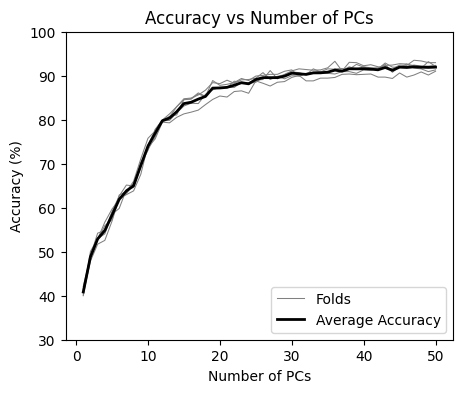

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
acc_pc_tot=load_pickle_s3(bucket_name, s3_file_path, dbutils)

# Plot accuracy as a function of number of PCs
plt.figure(figsize=(5, 4))

for num_fold in range(len(acc_pc_tot)):
    plt.plot(num_pc, acc_pc_tot[num_fold], 'gray', linewidth=0.75, label=f'Folds' if num_fold == 0 else "")

plt.plot(num_pc, acc_pc_tot.mean(axis=0), 'k', linewidth=2, label='Average Accuracy')

plt.xlabel('Number of PCs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of PCs')
plt.ylim(30, 100)
plt.legend()
plt.show()

As expected, here we see a progressive improvement in classification with more and more PC features (peaking at >90%) that is also consistent across folds. We also need to create a null distribution in the same way as before as a function of PC features used to determine statistical significance.

In [0]:
# Permute 100 times per fold (5x), per PC 
start_time = time.time()

num_pc = np.linspace(2, 50, 25, dtype='int')

acc_pc_permute_tot = []
for num_pc in num_pc:  # PC

    acc_pc_permute_pc = np.array([])
    for num_fold in range(len(train_idx_fold)): # Fold
        
        train_data = data_pca[train_idx_fold[num_fold],:]
        train_labels = labels[train_idx_fold[num_fold]]
        test_data = data_pca[test_idx_fold[num_fold],:]
        test_labels = labels[test_idx_fold[num_fold]]

        acc_pc_permute_fold = np.array([])
        for i in range(2):  # Iteration within pc
            acc_tmp = iteration_permute_PCs(train_data, train_labels, test_data, test_labels, loadings_da, num_pc, n_iterations=50)
            acc_pc_permute_fold=np.concatenate((acc_pc_permute_fold, acc_tmp), axis=0)

        acc_pc_permute_pc=np.concatenate((acc_pc_permute_pc, acc_pc_permute_fold), axis=0)

    acc_pc_permute_tot.append(acc_pc_permute_pc)

acc_pc_permute_tot = np.vstack(acc_pc_permute_tot)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time: {total_time:.2f} seconds")
print()

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc_permute.pkl'
save_pickle_s3(acc_pc_permute_tot, bucket_name, s3_file_path, dbutils)

Total time: 53994.49 seconds

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_NUM_PCS_acc_permute.pkl


Plot accuracy and null distributions (with statistical results) as a function of the number of PC features used

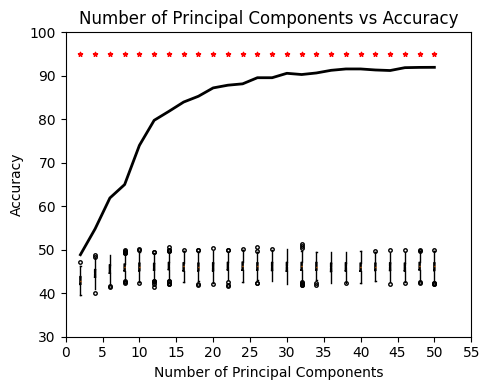

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc_permute.pkl'
acc_pc_permute_tot=load_pickle_s3(bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
acc_pc_tot=load_pickle_s3(bucket_name, s3_file_path, dbutils)

fig, ax = plt.subplots(figsize=(5, 4))

# Plot accuracy as a function of number of PCs
num_pc = np.linspace(2, 50, 25, dtype='int')
acc_pc_tot = np.mean(acc_pc_tot, axis=0)
acc_pc_tot = acc_pc_tot[num_pc-1]
ax.plot(num_pc, acc_pc_tot, linestyle='-', color='k', linewidth=2)

# perform permutation testing and plot null distribution
p_val_tot = []
for i in range(np.size(acc_pc_permute_tot, 0)):
    b = plt.boxplot(acc_pc_permute_tot[i], 'b', positions=[num_pc[i]], flierprops={'marker': '.', 'markersize': 5})

    # Permutation testing
    null_above_value = (acc_pc_permute_tot[i] > acc_pc_tot[i]).sum()
    p_val_tot.append(null_above_value/np.size(acc_pc_permute_tot[i],0))

# Visualize p-values
p_val_tot = np.array([float(num) for num in p_val_tot])
p_value_adj = false_discovery_control(p_val_tot)   

for i in range(len(p_value_adj)): 
    if p_value_adj[i] < 0.05:
        plt.scatter(num_pc[i], 95, s = 10, c = 'r', marker = "*")

ax.set_xlim(0, 55)
ax.set_xticks(range(0, 56, 5))
ax.set_xticklabels(range(0, 56, 5))
plt.ylim(30, 100)
ax.set_title('Number of Principal Components vs Accuracy')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

It is reassuring to see that the null distribution, or chance level, remains quite constant even when using more PC features. This provides even more confidence that the increasing classification accuracy is due to class-specific differences rather than chance. Given that the previous accuracy of ~48% was significant, it is also expected that all other results are also significant (red asterisks) even when accounting for multiple comparisons (i.e. false-discovery rate).

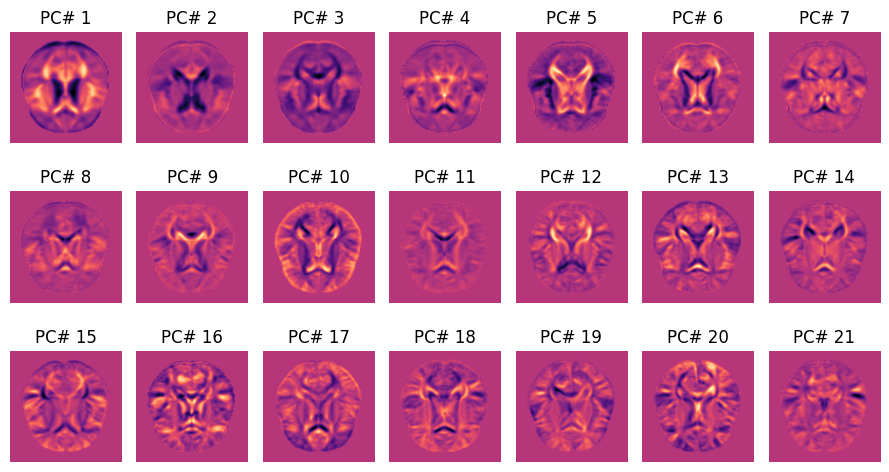

In [0]:
f, ax = plt.subplots(3, 7, figsize=(9, 6))
lim = 21
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/7).astype(int)
    idx2 = np.fmod(ipc,7).astype(int)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 12)
    plt.tight_layout()

Here we can see that for each of the top 21 PC's some brain regions are more strongly weighted than others (in either the positive or negative direction). It is important to note that it does not appear that each image used in this dataset came from the same location/slice within the brain. We do not know if certain slices are over- or under-represented in different AD classes and therefore cannot say with certainty whether specific anatomical structures drive different stages of AD.

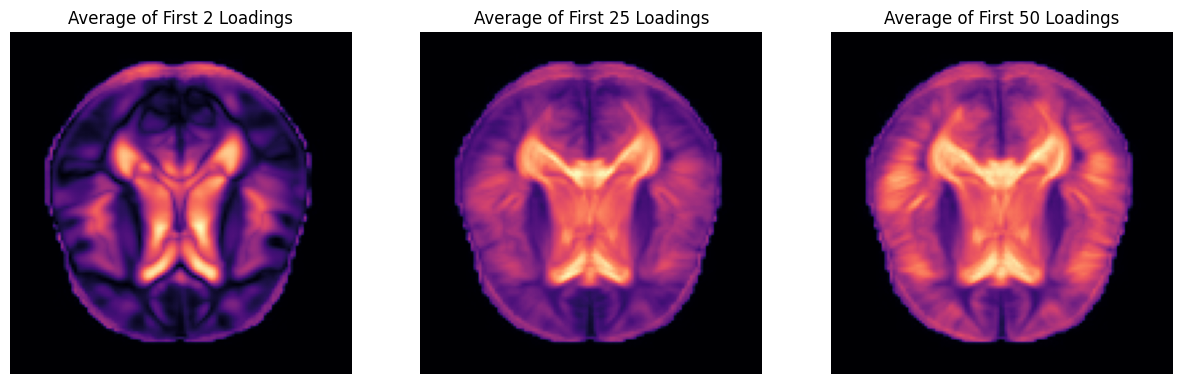

In [0]:
# Calculate average maps for first X PCs
loadings_abs = np.abs(loadings)
averages = [np.mean(loadings_abs[:, :n], axis=1) for n in [2, 25, 50]]
images = [avg.reshape(128, 128) for avg in averages]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Average of First 2 Loadings', 'Average of First 25 Loadings', 'Average of First 50 Loadings']

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='magma')
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

When examining cumulative absolute PC maps, it is clear that discriminatory information focuses on the lateral ventricles. However, improvements in classification are also linked with more lateral brain regions that become more apparent in the 25 and 50 PC maps that help achieve ~90% accuracy.